<a href="https://colab.research.google.com/github/asadstat/Data_analysis/blob/master/Lstm_%26_BiLstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/data/sentiment.csv',usecols=['domain','title','content','Sentiment'])
df.head()

,domain,title,content,Sentiment
0,marketbeat,Three Industrial Giants You Should Own In 2020,With the end of the year just around the corne...,Positive
1,marketbeat,Labor Stocks Are Going To Break Out In 2020,The labor markets were one of the most closely...,Positive
2,marketbeat,"Tesla (TSLA) Breaks Shipment Record, Beats Est...","It could be forgiven, that some might think th...",Positive
3,ciodive,"On the road to AI adoption, execs grapple with...",CIOs kicked off 2019 with AI as an item to wat...,Positive
4,instyle,Red Carpet Sustainability After Coronavirus Sh...,When the coronavirus pandemic is over and life...,Positive


In [ ]:
df.shape
df=df[:5000]
df['Sentiment']=df['Sentiment'].apply(lambda x: 1 if x=='Positive' else 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df['Sentiment'].value_counts()

In [ ]:
df_positive = df[df['Sentiment']==1]
df_negative = df[df['Sentiment']==0]
df_positive_downsampled = df_positive.sample(df_negative.shape[0])
df_balanced = pd.concat([df_positive_downsampled, df_negative])

In [ ]:
df_balanced['Sentiment'].value_counts()

In [ ]:
df=df_balanced.sample(950)
df.to_csv("senti.csv")

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/data/senti.csv',usecols=['domain','title','content','Sentiment'])
df.head()

,domain,title,content,Sentiment
0,express,Coronavirus warning: Leaked letter IGNORED by ...,"The Royal Sussex County Hospital in Brighton,...",0
1,express,"Bitcoin stages another attempt to break $10,000",BTC began the day with a steady upward movem...,1
2,cnbc,"Assets fall as China virus fears grow, S.Afric...",tumbles@ * China virus stokes fears of economi...,0
3,marketscreener,U.S. Confirms First Person-to-Person Spread of...,"By Brianna Abbott, Katie Camero and Erin Mende...",1
4,cnbc,Coronavirus damages China's auto industry as o...,The extended factory shutdown in China is cost...,1


In [ ]:
df.head()

,domain,title,content,Sentiment
0,express,Coronavirus warning: Leaked letter IGNORED by ...,"The Royal Sussex County Hospital in Brighton,...",0
1,express,"Bitcoin stages another attempt to break $10,000",BTC began the day with a steady upward movem...,1
2,cnbc,"Assets fall as China virus fears grow, S.Afric...",tumbles@ * China virus stokes fears of economi...,0
3,marketscreener,U.S. Confirms First Person-to-Person Spread of...,"By Brianna Abbott, Katie Camero and Erin Mende...",1
4,cnbc,Coronavirus damages China's auto industry as o...,The extended factory shutdown in China is cost...,1


In [ ]:
X=df.drop('Sentiment',axis=1)
X.head()

,domain,title,content
0,express,Coronavirus warning: Leaked letter IGNORED by ...,"The Royal Sussex County Hospital in Brighton,..."
1,express,"Bitcoin stages another attempt to break $10,000",BTC began the day with a steady upward movem...
2,cnbc,"Assets fall as China virus fears grow, S.Afric...",tumbles@ * China virus stokes fears of economi...
3,marketscreener,U.S. Confirms First Person-to-Person Spread of...,"By Brianna Abbott, Katie Camero and Erin Mende..."
4,cnbc,Coronavirus damages China's auto industry as o...,The extended factory shutdown in China is cost...


In [ ]:
X.shape

(950, 3)

In [ ]:
y=df['Sentiment']
y.head()

In [ ]:
y.shape

(950,)

In [ ]:
messages=X.copy()
messages.head()

,domain,title,content
0,express,Coronavirus warning: Leaked letter IGNORED by ...,"The Royal Sussex County Hospital in Brighton,..."
1,express,"Bitcoin stages another attempt to break $10,000",BTC began the day with a steady upward movem...
2,cnbc,"Assets fall as China virus fears grow, S.Afric...",tumbles@ * China virus stokes fears of economi...
3,marketscreener,U.S. Confirms First Person-to-Person Spread of...,"By Brianna Abbott, Katie Camero and Erin Mende..."
4,cnbc,Coronavirus damages China's auto industry as o...,The extended factory shutdown in China is cost...


In [ ]:
import re
import nltk
nltk.download("stopwords") 
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
ps=PorterStemmer()
corpus=[]
for i in range(len(messages)):
    review=re.sub('[^a-zA-Z]',' ',messages['content'][i])
    review=review.lower()
    review=review.split()
    review=[ps.stem(word) for word in review if not word in stopwords.words('english')]
    review=' '.join(review)
    corpus.append(review)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df=df_balanced.sample(950)

In [ ]:
voc_size=5000
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [ ]:
onehot_repr=[one_hot(words,voc_size) for words in corpus]
onehot_repr

In [ ]:
sent_length=20
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[3803 2439 3648 ... 2589  420 3956]
 [3591 3632 4143 ... 2589  420 3956]
 [1272  185 3071 ... 1402  247 1832]
 ...
 [4173 1663 3212 ... 3547 3730 2555]
 [2001 2701 4992 ... 2589  420 3956]
 [3303 2159 2882 ...  737 4178 4824]]


LSTM

In [ ]:
from tensorflow.keras.layers import Dropout
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.5))
model.add(LSTM(200))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_final,y_final,test_size=0.40,random_state=42)

In [ ]:
history_lstm =model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

In [ ]:
from keras.backend import clear_session
clear_session()

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9509
Testing Accuracy:  0.5632


In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history_lstm):
    acc = history_lstm.history['accuracy']
    val_acc = history_lstm.history['val_accuracy']
    loss = history_lstm.history['loss']
    val_loss = history_lstm.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


In [ ]:
print(history_lstm.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


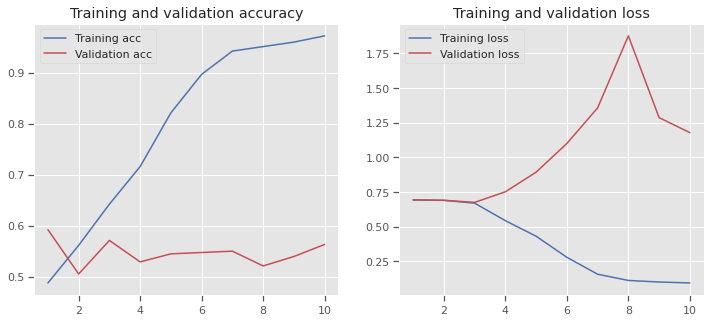

In [ ]:
plot_history(history_lstm)

In [ ]:
pred_lstm = (model.predict(X_test) > 0.5).astype("int32")
#from sklearn.metrics import accuracy_score
#print(accuracy_score(y_test,y_pred))
print(pred_lstm)

In [ ]:
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
# Calculate the accuracy score
accuracy_lstm = metrics.accuracy_score(y_test,pred_lstm)
print(accuracy_lstm)
Conf_metrics_lstm = metrics.confusion_matrix(y_test,pred_lstm, labels=[1, 0])

0.6105263157894737


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
labels = [1, 0]
print(classification_report(y_test, pred_lstm))
pd.DataFrame(confusion_matrix(y_test, pred_lstm), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.67      0.60      0.63        53
           1       0.55      0.62      0.58        42

    accuracy                           0.61        95
   macro avg       0.61      0.61      0.61        95
weighted avg       0.62      0.61      0.61        95



,1,0
1,32,21
0,16,26


In [ ]:
conf_lstm = metrics.confusion_matrix(y_test,pred_lstm)
conf_lstm

array([[32, 21],
       [16, 26]])

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

np.random.seed(42)  # for reproducibility
sns.set(rc={"figure.figsize": (4, 4)})
sns.set_style("ticks")

Text(0.5, 31.939999999999984, 'Predicted label')

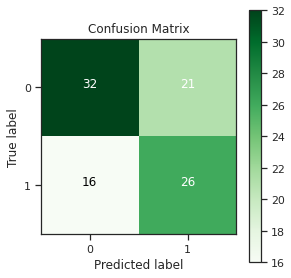

In [ ]:
classes = [1, 0]
# plot confusion matrix
plt.imshow(conf_lstm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf_lstm.max() / 2.
for i, j in itertools.product(range(conf_lstm.shape[0]), range(conf_lstm.shape[1])):
    plt.text(j, i, format(conf_lstm[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf_lstm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
probs = model.predict(X_test)
preds=probs 

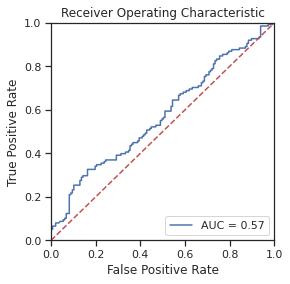

In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Bi Lstm model

In [ ]:
import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Bidirectional

In [ ]:
from tensorflow.keras.layers import Dropout
embedding_vector_features=40
model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(200)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_final,y_final,test_size=0.20,random_state=42)

In [ ]:
history_bilstm =model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

In [ ]:
pred_bilstm = (model.predict(X_test) > 0.5).astype("int32")
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,pred_bilstm))

In [ ]:
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
# Calculate the accuracy score
accuracy_bilstm = metrics.accuracy_score(y_test,pred_bilstm)
print(accuracy_bilstm)
Conf_metrics_bilstm = metrics.confusion_matrix(y_test,pred_bilstm, labels=['1', '0'])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
labels = ['1', '0']
print(classification_report(y_test, pred_bilstm))
pd.DataFrame(confusion_matrix(y_test, pred_bilstm), index=labels, columns=labels)

In [ ]:
conf_bilstm = metrics.confusion_matrix(y_test,pred_bilstm)
conf_bilstm

In [ ]:
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

np.random.seed(42)  # for reproducibility
sns.set(rc={"figure.figsize": (4, 4)})
sns.set_style("ticks")

In [ ]:
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf_bilstm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf_bilstm.max() / 2.
for i, j in itertools.product(range(conf_bilstm.shape[0]), range(conf_bilstm.shape[1])):
    plt.text(j, i, format(conf_bilstm[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf_bilstm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
pred=model.predict(X_test)
print(pred)

In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
from keras.backend import clear_session
clear_session()

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history_bilstm):
    acc = history_bilstm.history['accuracy']
    val_acc = history_bilstm.history['val_accuracy']
    loss = history_bilstm.history['loss']
    val_loss = history_bilstm.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


In [ ]:
plot_history(history_bilstm)